# Probabilistic Programming 1: Regression & Classification
## Variational inference

In this lesson we are going to use variational inference for regression and classification. We will use ForneyLab.jl to specify a model and run an inference procedure. While Probabilistic Programming requires some specialised knowledge in terms of probability theory and Bayesian inference, implementing an inference procedure is straightforward once you have the right tools.

### Preliminaries

- Goal 
  - Learn to estimate regression parameters using a variational inference procedure.
- Materials        
  - Mandatory
    - These lecture notes.
    - [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
  - Optional
    - Getting started with [ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).
    - [Demos in ForneyLab](https://github.com/biaslab/ForneyLab.jl/tree/v0.10.0/demo)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

## Introduction to ForneyLab

[ForneyLab](https://github.com/biaslab/ForneyLab.jl) is a Probabilistic Programming toolbox developed inhouse at [BIASLab](https://biaslab.github.io/). ForneyLab utilises the FFG formalism that you are familiar with by now to describe models. Inference is performed through variational procedures or, if applicable, exact inference. This is the core feature of ForneyLab: a large library of analytical update rules similar to what you have derived so far. This provides fast, deterministic inference with convergence guarantees, provided you supply the right generative model.
Things to keep in mind when using ForneyLab:
1. It is optimised for Dynamical Systems and time series data. It'll be fast in these circumstances.
2. Relies on deterministic update rules - you will get the same result each time.
3. If you find a bug, please tell us :) 

Now, let's work through an example using ForneyLab.

In [1]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate()

using Logging; disable_logging(LogLevel(0))
using StatsPlots
using ForneyLab
import Distributions: Uniform, Normal, rand

Activating environment at `~/Dropbox/Courses/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/BMLIP/lessons/notebooks/probprog/workspace/Project.toml`


### Data generation

We'll generate a simple regression problem setting. Given a data set $x = (x_1, \dots, x_N)$ of $N$ samples, we generate the set of observations $y = (y_1, \dots, y_N)$ via: 

$$ y = f(x) + \epsilon$$ 

where $f(x) = x*w_1 + w_2$ and $\epsilon \sim \mathcal{N}(0, \sigma)$. We summarize the slope coefficient and intercept into a single weight vector, $w = [w_1\ w_2]$. We will use the name "covariates" for $x$ and "responses" for $y$.

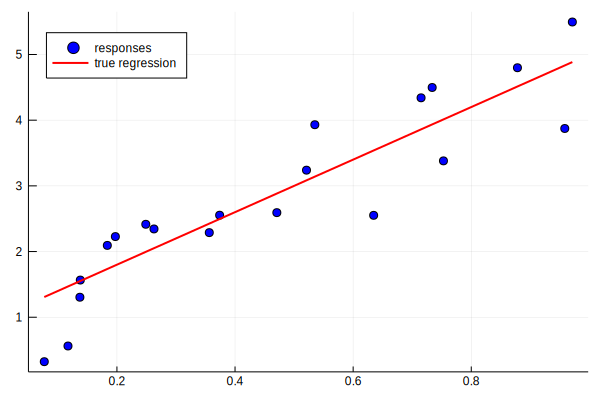

In [2]:
# Number of samples
N = 20

# Parameters
true_w = [4.0 1.0]
true_σ = 1/2

function generate_data(true_w, true_σ; num_samples=10)
    "Generate data according to y = w'*x + ϵ"
    
    # Covariates
    x = rand(Uniform(0,1), num_samples)
    
    # Linear function of covariates
    fx = x.* true_w[1] .+ true_w[2] 
    
    # Generate Gaussian noise
    ϵ = rand(Normal(0, true_σ), num_samples)
    
    # Responses consist of the linear mapping plus noise
    y = fx + ϵ
    
    # Return covariates and responses
    return y, x
end

# Generate data
responses, covariates = generate_data(true_w, true_σ, num_samples=N)

# True regression of the covariates
fx = covariates*true_w[1] .+ true_w[2]

# Visualize data
scatter(covariates, responses, color="blue", label="responses", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

### Model Specification

We need to specify our model using ForneyLab. Firstly, we will formulate the linear function using a dot product:

$$f(x) = [w_1\ w_2] \cdot [x\ 1]^{\top} \, .$$

We know that the responses are generated via a linear function of the covariates and Gaussian noise:

$$y \sim \mathcal{N}(f(x),\sigma_y)\, .$$ 

We know that the weights are real numbers and that they can be negative. It makes sense therefore to put a Gaussian prior on them:

$$ w \sim \mathcal{N}(\mu_w, \sigma_w) \, .$$

For now, this is all we need. We're going to specify these two equations within ForneyLab. First, we initialize a factor graph:

In [3]:
g = FactorGraph();

Now that we have a FactorGraph, we can start adding variables to it. This is the actual point where we specify our probabilistic model. To keep it simple, let's start by defining a model for a single x/y pair.


In [4]:
# Parameters for priors
μ_w = [0. 0.]
σ_w = [1. 0.; 0. 1.]
σ_y = 1.

# In ForneyLab we use the @RV macro to denote Random Variables
@RV x

# Define a prior over the weights
@RV w ~ GaussianMeanVariance(μ_w, σ_w)

# Response model is Gaussian function of the linear mapping between weights and covariates
@RV y ~ GaussianMeanVariance(dot(w, x), σ_y)

# Visualise the graph
ForneyLab.draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7541005550252670712 -->
 
 7541005550252670712 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 9628606838948033064 -->
 
 9628606838948033064 
 
 clamp_3 
 
<!-- 7541005550252670712--9628606838948033064 -->
 
 7541005550252670712--9628606838948033064 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 4459187808987894140 -->
 
 4459187808987894140 
 
 dot 
 dotproduct_1 
 
<!-- 7541005550252670712--4459187808987894140 -->
 
 7541005550252670712--4459187808987894140 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 11071609947939723256 -->
 
 11071609947939723256 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 4459187808987894140--11071609947939723256 -->
 
 4459187808987894140--11071609947939723256 
 
 w 
 1 out 
 3 in2 
 
<!-- 3963987036801915135 -->
 
 3963987036801915135 
 
 clamp_1 
 
<!-- 3356806062481641313 -->
 
 3356806062481641313 
 
 clamp_2 
 
<!-- 11071609947939723256--3963987036801915135 -->
 
 11071609947939723256--3963987036801915135 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 11071609947939723256--3356806062481641313 -->
 
 11071609947939723256--3356806062481641313 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 42442672867508324372 -->
 
 42442672867508324372 
 
<!-- 42442672867508324372--4459187808987894140 -->
 
 42442672867508324372--4459187808987894140 
 
 x 
 2 in1 
 
<!-- 166372607349211812332 -->
 
 166372607349211812332 
 
<!-- 166372607349211812332--7541005550252670712 -->
 
 166372607349211812332--7541005550252670712 
 
 y 
 1 out

If you take a look at the graph, you will see that it has some open edges for x and y. This is where we want to feed in our data. To do so in ForneyLab, we designate them as placeholders. This means that we do not give them a value immediately but want them to take one a value later.

In [5]:
# We designate the covariates x to have two dimensions (the last one being all 1)
placeholder(x, :x, dims=(2,))

# Designate the observation variable
placeholder(y, :y);

Now that we have our model, it is time to infer parameters. ForneyLab includes Sum-Product as an exact inference algorithm. The details of the procedure are not important at this time, so feel free to treat it as a "magic inference button".
ForneyLab works by directly generating new Julia code containing the inference algorithm. When we parse this code, we get a function (step!) which we can then run to update the recognition factors.

If you are feeling adventurous, feel free to experiment with some of the other inference tools available in ForneyLab. Do you get different results?

In [6]:
# We specify a recognition distribution
q = RecognitionFactorization(w, ids=[:w])

# Call the variational algorithm
algo = variationalAlgorithm(q) 

# Evaluate the generated code to get the step! function
eval(Meta.parse(algo)) 

stepw! (generic function with 3 methods)

Next we need to create a dictionary with our data. Since our model is only for a single data point, we create a dictionary holding just one random x/y pair

In [7]:
data = Dict(:x => [covariates[10]; 1],
            :y => responses[10]);

Now, we feed our data dictionary into the step! function, do inference and observe the results! For clarity we have written the model specification below as well so you can get a sense of what a full ForneyLab program looks like.

In [8]:
g = FactorGraph()

# Parameters for priors
μ_w = [2.; 0.]
σ_w = 10*[1. 0.; 0. 1.]
σ_y = 1.

# Specify probabilistic model
@RV x 
@RV w ~ GaussianMeanVariance(μ_w, σ_w)
@RV y ~ GaussianMeanVariance(dot(w, x), σ_y)

# Denote placeholders
placeholder(x, :x, dims=(2,)) 
placeholder(y, :y);

# Specify recognition distribution
q = RecognitionFactorization(w, ids=[:w])

# Generate inference algorithm
algo = variationalAlgorithm(q) 
eval(Meta.parse(algo)) 

# Set up data dictionary
data = Dict(:x => [covariates[10]; 1],
            :y => responses[10]);

# Do inference
marginals = stepw!(data)

# Print results
println("Posterior mean: ", mean(marginals[:w]))
println("Posterior Variance: ", var(marginals[:w]))

Posterior mean: [3.1041918276040334, 2.0635108853017456]
Posterior Variance: [7.934586004951369, 2.786739995405315]


That wasn't particurlarly accurate because we only used a single data point. Let's create a new model that takes in the full data set instead and see if we get better results.

In [9]:
g2 = FactorGraph()

# Parameters for priors
μ_w = [2.; 0.]
σ_w = 10*[1. 0.; 0. 1.]
σ_y = 1.

# Create vectors to hold variables for all data points
x = Vector{Variable}(undef, N) 
y = Vector{Variable}(undef, N)

# Define a prior over the weights. These are shared for all data points
@RV w ~ GaussianMeanVariance(μ_w, σ_w)

# Loop over the dataset
for i in 1:N
    
    # We can use indexing to fill a vector with random variables
    @RV x[i] 
    @RV y[i] ~ GaussianMeanVariance(dot(w, x[i]), σ_y) 
    
    # To define placeholders in vectors, we use the index flag
    placeholder(x[i], :x, index=i, dims=(2,)) 
    placeholder(y[i], :y, index=i)
end

# Specify recognition distribution
q = RecognitionFactorization(w, ids=[:w])

# Generate inference algorithm
algo = variationalAlgorithm(q) 
eval(Meta.parse(algo)) 

# Now we can fit the entire data set in our model!
data = Dict(:x => [[covariates[i]; 1] for i in 1:N],
            :y => responses)

# Perform inference and observe the results
marginals = stepw!(data)
println("Posterior mean: ", mean(marginals[:w]))
println("Posterior Variance: ", var(marginals[:w]))

Posterior mean: [4.109199732725262, 0.911033782221029]
Posterior Variance: [0.5585047889999004, 0.16837568157509697]


We can make predictions and visualize the result.

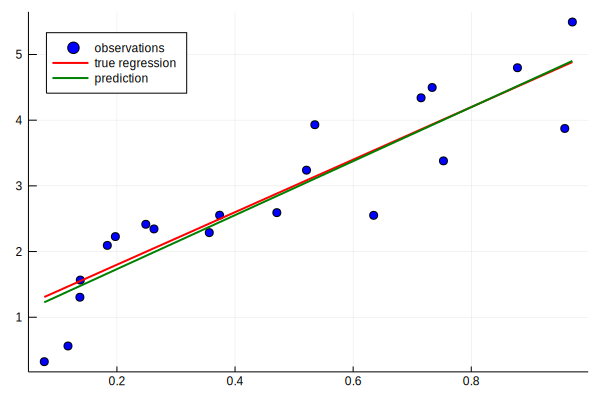

In [10]:
# Extract estimated weights
w_hat = mean(marginals[:w])

# Make predictions
y_hat = covariates * w_hat[1] .+ w_hat[2]

# Visualize true data and observations
scatter(covariates, responses, color="blue", label="observations", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

# Overlay predictions
plot!(covariates, y_hat, color="green", label="prediction", linewidth=2)

### Assignment: higher dimensional covariates

Most practical problems contain multiple covariates. Can you adjust the model specified above to fit the data set generated below?

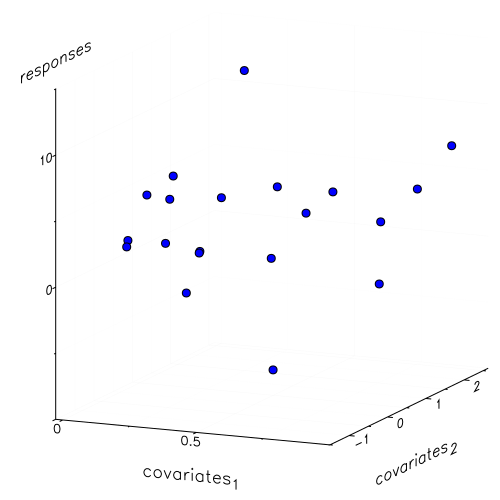

In [36]:
# Number of samples
N = 20

# Parameters
true_w = [-1.0 4.0 1.0]
true_σ = 1/2

function generate_data(true_w, true_σ; num_samples=10)
    "Generate data according to y = w'*x + ϵ"
    
    # Covariates
    X = [rand(Uniform(0,1), num_samples) rand(Normal(1,1), num_samples)]
    
    # Linear function of covariates
    fX = X[:,1].*true_w[1] .+ X[:,2].*true_w[2] .+ true_w[3] 
    
    # Generate Gaussian noise
    ϵ = rand(Normal(0, true_σ), num_samples)
    
    # Responses consist of the linear mapping plus noise
    y = fX + ϵ
    
    # Return covariates and responses
    return y, X
end

# Generate data
responses, covariates = generate_data(true_w, true_σ, num_samples=N)

fX = covariates[:,1].*true_w[1] .+ covariates[:,2].*true_w[2] .+ true_w[3] 

# Visualize data
scatter(covariates[:,1], 
        covariates[:,2], 
        responses, 
        color="blue", 
        label="", 
        xlabel="covariates_1", 
        ylabel="covariates_2", 
        zlabel="responses", 
        size=(500,500))

In [ ]:
### Your code here

### Assignment: informativeness of priors

We chose a prior distribution for the weights, $w \sim \mathcal{N}([2\ 0], 10\cdot\mathcal{I})$. As you've seen in the introduction notebook, the parameters of the final recognition distribution still depend on the parameters of the prior distribution. This means the result we've just gotten will be different for different priors. Play around with other choices of prior distribution parameters. 

Try a sharp prior on the wrong value (small variance, mean away from true_w). Where does that get you? And what if you use a very flat prior (super high variance)? 

In [12]:
### Your code here